# 1. Exploratory Data Analysis (EDA)



## <font color='darkblue'>Traffic Volume Dataset</font> 

In [1]:
import numpy as np
import pandas as pd
import sklearn
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('https://aisgaiap.blob.core.windows.net/aiap5-assessment-data/traffic_data.csv')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,New Years Day,263.49,0.0,0,58,Clouds,broken clouds,2013-01-01 00:00:00,1439
1,None,263.78,0.0,0,40,Clouds,scattered clouds,2013-01-01 01:00:00,1502
2,None,264.16,0.0,0,75,Snow,heavy snow,2013-01-01 02:00:00,933
3,None,263.95,0.0,0,90,Clouds,overcast clouds,2013-01-01 03:00:00,576
4,None,263.65,0.0,0,90,Clouds,overcast clouds,2013-01-01 04:00:00,372


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8573 entries, 0 to 8572
Data columns (total 9 columns):
holiday                8573 non-null object
temp                   8573 non-null float64
rain_1h                8573 non-null float64
snow_1h                8573 non-null int64
clouds_all             8573 non-null int64
weather_main           8573 non-null object
weather_description    8573 non-null object
date_time              8573 non-null object
traffic_volume         8573 non-null int64
dtypes: float64(2), int64(3), object(4)
memory usage: 602.9+ KB


* No missing value in the dataset. 
* There are 4 features of type object and 4 of type numeric.

## <font color='darkblue'>1.1 Analysis on Numerical Features</font>

In [4]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,8573.000000,8573.000000,8573.0,8573.000000,8573.000000
mean,278.976352,0.161284,0.0,52.560947,3286.762160
std,13.322459,1.439626,0.0,37.470062,2028.322769
min,244.820000,0.000000,0.0,0.000000,164.000000
25%,269.460000,0.000000,0.0,1.000000,1193.000000
50%,277.330000,0.000000,0.0,64.000000,3344.000000
75%,290.400000,0.000000,0.0,90.000000,5001.000000
max,308.240000,55.630000,0.0,100.000000,7217.000000


* snow_1h takes zero values only, indicating zero occurrence of snowing.
* snow_1h column can be dropped since the variance is zero and thus will not improve the performance of the model

In [5]:
df.corr()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
temp,1.000000,0.072393,NaN,-0.229801,0.152234
rain_1h,0.072393,1.000000,NaN,0.037649,-0.032439
snow_1h,NaN,NaN,NaN,NaN,NaN
clouds_all,-0.229801,0.037649,NaN,1.000000,-0.002702
traffic_volume,0.152234,-0.032439,NaN,-0.002702,1.000000


* Each feature has very low correlation with the output variable traffic_volume
* Correlation between features is very low as well.

In [6]:
df['rain_1h'].value_counts(normalize=True)

0.00     0.926047
0.25     0.024029
0.51     0.005832
0.38     0.004433
0.76     0.002799
           ...   
1.13     0.000117
1.07     0.000117
0.32     0.000117
44.45    0.000117
55.63    0.000117
Name: rain_1h, Length: 98, dtype: float64

* More than 90% of the observations take values of 0.
* Convert continuous variable into discrete variables taking values of 0 or 1 only (set value to 1 if rain amount > 0mm)

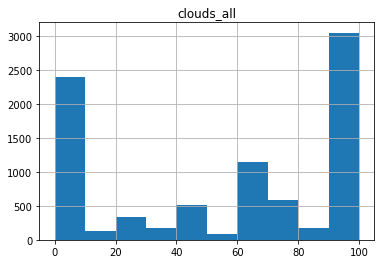

In [7]:
df.hist(column='clouds_all')
plt.show()

* From the histogram plot, it is observed that the feature clouds_all can be converted from continuous to a discrete variable
* Binning can be performed on clouds_all feature.

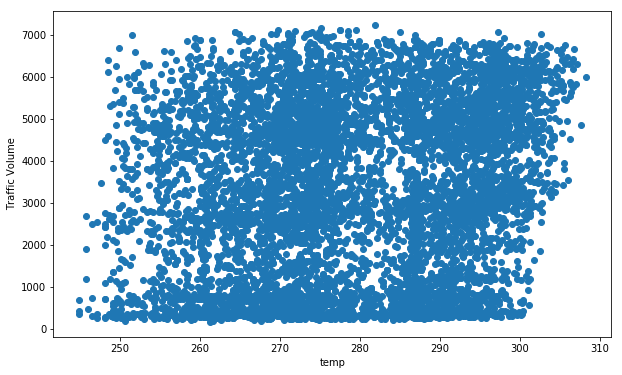

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df['temp'], df['traffic_volume'])
ax.set_xlabel('temp')
ax.set_ylabel('Traffic Volume')
plt.show()

* From the scatter plot, temp is weakly correlated with the output variable
* Drop temp column 

## <font color='darkblue'>1.2 Analysis on Features of type Object</font>

In [9]:
df.describe(include=['object', 'bool'])

,holiday,weather_main,weather_description,date_time
count,8573,8573,8573,8573
unique,11,10,33,7294
top,None,Clouds,sky is clear,2013-05-19 10:00:00
freq,8563,3136,1494,6


In [10]:
duplicateRowsDF = df[df.duplicated(['date_time'])]
print(duplicateRowsDF)

     holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
40      None  261.61     0.00        0          90         Mist   
42      None  262.18     0.00        0          90         Haze   
44      None  262.54     0.00        0          90         Haze   
58      None  263.93     0.00        0          90         Mist   
59      None  263.93     0.00        0          90          Fog   
...      ...     ...      ...      ...         ...          ...   
8499    None  266.70     0.00        0          64         Snow   
8532    None  251.11     0.00        0          90         Haze   
8534    None  253.34     0.00        0          90         Haze   
8540    None  256.01     0.76        0          90         Snow   
8542    None  255.81     0.25        0          90         Snow   

     weather_description            date_time  traffic_volume  
40                  mist  2013-01-02 15:00:00            4836  
42                  haze  2013-01-02 16:00:00            5597  
44 

* It is observed that the count and unique statistics for date_time feature is not equal (8573 != 7294), indicating that there are duplicated records.
* It is also observed that weather_description has little/no impact on the output variable.

* weather_description column can be dropped. Weather_main, being less detailed than weather_description, can be dropped as well.
* Duplicated rows of date_time records can be dropped since the existence of the daily seasonality trend is highly probable.

### Exploring seasonality trend

In [11]:
time = df['date_time'].apply(lambda x: x.split(' ')[1].split(':')[0])
num_hourly_intervals = len(time.unique())
df["date_time"] = df["date_time"].str.split().str[1]



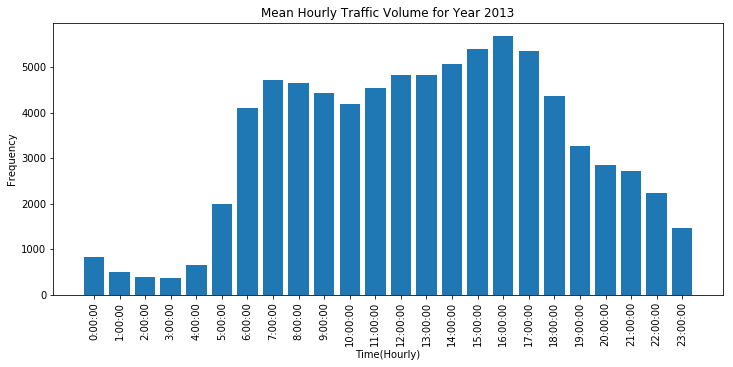

In [12]:
hourly_time = [timedelta(minutes=60*x) for x in range(0, num_hourly_intervals)]
mean_traffic_data = df[['date_time', 'traffic_volume']]
mean_traffic_data = mean_traffic_data.groupby('date_time', as_index=False).mean()

plt.figure(figsize=(12,5))
plt.title('Mean Hourly Traffic Volume for Year 2013')
plt.xlabel('Time(Hourly)')
plt.ylabel('Frequency')
plt.bar(mean_traffic_data['date_time'], mean_traffic_data['traffic_volume'])
plt.xticks(np.arange(num_hourly_intervals), hourly_time, rotation='vertical')
plt.show(block=False)


* From the plot above, it is observed that there is daily seasonality trend.
* To extract the hour of a timestamp into a new column during the feature engineering phase

In [13]:
df1 = pd.read_csv('https://aisgaiap.blob.core.windows.net/aiap5-assessment-data/traffic_data.csv', 
                  usecols = ["date_time", "traffic_volume"])

In [14]:
days_mapping = {0:'Mon', 1:'Tues', 2:'Wed', 3:'Thurs', 4:'Fri', 5:'Sat', 6:'Sun'}
def getDayOfWeek(date):
    int_day = datetime.strptime(date, '%Y %m %d').weekday()
    return (days_mapping[int_day])

In [15]:
date = df1['date_time'].apply(lambda x: x.split(' ')[0].replace('-',' '))
day_of_week = date.apply(lambda x: getDayOfWeek(x))
days_week_count = len(day_of_week.unique())
#df1["date_time"] = df1["date_time"].str.split().str[0].apply(lambda x: x.replace('-',' '))
#df1["date_time"] = df1['date_time'].apply(lambda x: getDayOfWeek(x))
df1["date_time"] = day_of_week

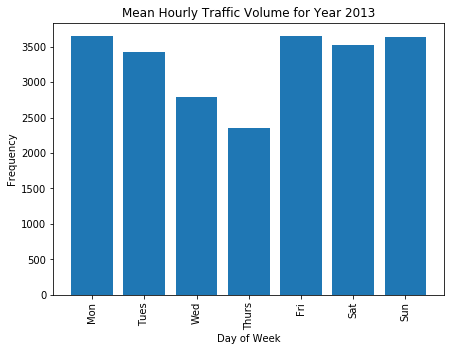

In [16]:
day_labels = list(days_mapping.values())
mean_traffic_data_weekly = df1[['date_time', 'traffic_volume']]
mean_traffic_data_weekly = mean_traffic_data_weekly.groupby('date_time', as_index=False).mean()

plt.figure(figsize=(7,5))
plt.title('Mean Hourly Traffic Volume for Year 2013')
plt.xlabel('Day of Week')
plt.ylabel('Frequency')
plt.bar(mean_traffic_data_weekly['date_time'], mean_traffic_data_weekly['traffic_volume'])
plt.xticks(np.arange(days_week_count), day_labels, rotation='vertical')
plt.show(block=False)


* From the plot above, it is observed that there is weekly seasonality trend.
* To extract the day of week of a timestamp into a new column during the feature engineering phase